In [1]:
import pandas as pd
import numpy as np
import random as rnd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
train_df=pd.read_csv('../data/train.csv')
test_df=pd.read_csv('../data/test.csv')

In [3]:
train_df.columns[np.logical_not(train_df.columns.isin(test_df.columns))]

Index(['Survived'], dtype='object')

In [4]:
test_df['Survived']=np.nan
combined=pd.concat([train_df,test_df])

In [5]:
train_df.apply(lambda x:np.sum(pd.isnull(x)),axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
train_df.loc[:,['Pclass','Survived']].groupby('Pclass').mean().sort_values(by='Survived',ascending=False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [8]:
train_df[['Sex','Survived']].groupby('Sex').mean().sort_values('Survived',ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


In [9]:
pd.pivot_table(train_df,index=['Sex','Pclass'],columns='Parch',values='Survived',aggfunc=np.mean)

Parch                 0         1         2    3    4     5    6
Sex    Pclass                                                   
female 1       0.984375  1.000000  0.846154  NaN  NaN   NaN  NaN
       2       0.888889  0.944444  1.000000  1.0  NaN   NaN  NaN
       3       0.588235  0.480000  0.320000  0.5  0.0  0.25  0.0
male   1       0.363636  0.285714  0.625000  NaN  0.0   NaN  NaN
       2       0.089888  0.500000  0.400000  NaN  NaN   NaN  NaN
       3       0.121622  0.266667  0.166667  0.0  0.0  0.00  NaN

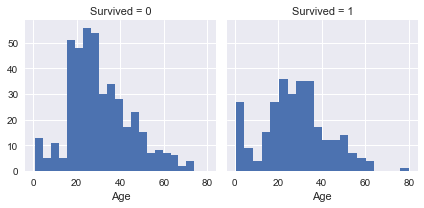

In [10]:
g=sns.FacetGrid(train_df,col='Survived')
g.map(plt.hist,'Age',bins=20)

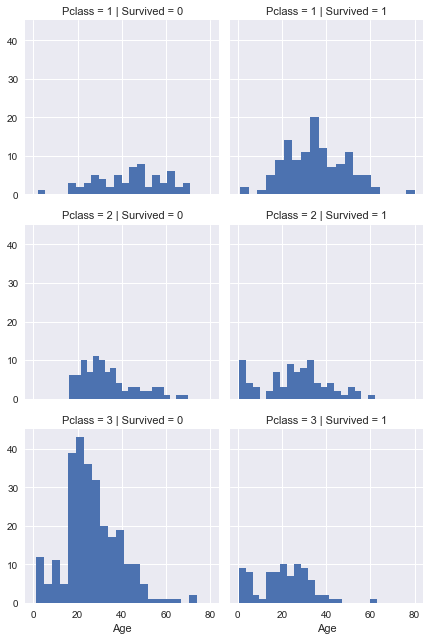

In [11]:
g=sns.FacetGrid(train_df,col='Survived',row='Pclass')
g.map(plt.hist,'Age',bins=20)
g.add_legend()

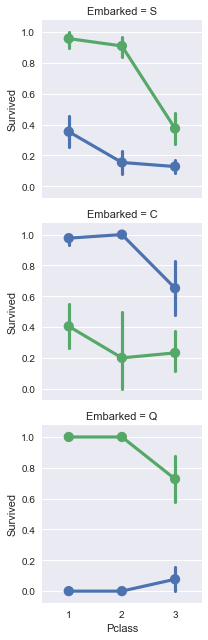

In [12]:
grid=sns.FacetGrid(train_df,row='Embarked')
grid.map(sns.pointplot,'Pclass','Survived','Sex',palette='deep')

In [13]:
combine=[train_df,test_df]

In [14]:
train_df=train_df.drop(['Ticket','Cabin'],axis=1)
test_df=test_df.drop(['Ticket','Cabin'],axis=1)
combine=[train_df,test_df]

In [15]:
for dataset in combine:
    dataset['Title']=dataset['Name'].str.extract('(\w+)\.',expand=False)

for dataset in combine:
    dataset['Title']=dataset['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')
    dataset['Title']=dataset['Title'].replace('Mlle','Miss')
    dataset['Title']=dataset['Title'].replace('Ms','Miss')
    dataset['Title']=dataset['Title'].replace('Mme','Mrs')

title_mapping={'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Rare':5}
for dataset in combine:
    dataset['Title']=dataset['Title'].map(title_mapping)
    dataset['Title']=dataset['Title'].fillna(0)

In [16]:
train_df=train_df.drop(['Name','PassengerId'],axis=1)
test_df=test_df.drop(['Name'],axis=1)
combine=[train_df,test_df]

In [17]:
for dataset in combine:
    dataset['Sex']=dataset['Sex'].map({'female':1,'male':0}).astype('int')
    
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


In [18]:
guess_age=np.zeros((2,3))
for dataset in combine:
    for i in range(0,2):
        for j in range(0,3):
            guess_df=dataset[(np.logical_and(dataset['Sex']==i,dataset['Pclass']==j+1))]['Age'].dropna()
            age_guess=guess_df.median()
            guess_age[i,j]=age_guess

for dataset in combine:
    for i in range(0,2):
        for j in range(0,3):
            dataset.loc[np.logical_and.reduce((dataset['Age'].isnull(),dataset['Sex']==i,dataset['Pclass']==j+1)),'Age']=guess_age[i,j]
    dataset['Age']=dataset['Age'].astype('int')

for dataset in combine:
    dataset['AgeBand']=pd.cut(dataset['Age'],5)

In [19]:
for dataset in combine:
    dataset.loc[dataset['Age']<=16,'Age']=0
    dataset.loc[np.logical_and(dataset['Age']>16,dataset['Age']<=32),'Age']=1
    dataset.loc[np.logical_and(dataset['Age']>32,dataset['Age']<=48),'Age']=2
    dataset.loc[np.logical_and(dataset['Age']>48,dataset['Age']<=64),'Age']=3
    dataset.loc[dataset['Age']>64,'Age']=4
    dataset.drop('AgeBand',axis=1,inplace=True)

In [20]:
for dataset in combine:
    dataset['FamilySize']=dataset['SibSp']+dataset['Parch']+1


In [21]:
for dataset in combine:
    dataset['IsAlone']=0
    dataset.loc[dataset['FamilySize']==1,'IsAlone']=1

In [22]:
for dataset in combine:
    dataset.drop(['Parch','SibSp','FamilySize'],axis=1,inplace=True)

In [23]:
for dataset in combine:
    dataset['Age*Class']=dataset.Age*dataset.Pclass

In [24]:
train_df.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,S,1,0,3
1,1,1,1,2,71.2833,C,3,0,2


In [25]:
freq_port=train_df.Embarked.dropna().mode()[0]
train_df['Embarked']=train_df['Embarked'].fillna(freq_port)

In [26]:
for dataset in combine:
    dataset.Embarked=dataset.Embarked.map({'S':0,'C':1,'Q':2}).astype('int')

In [27]:
for dataset in combine:
    dataset.Fare.fillna(dataset.Fare.dropna().median(),inplace=True)
    dataset.loc[dataset.Fare<=7.91,'Fare']=0
    dataset.loc[np.logical_and(dataset.Fare>7.91,dataset.Fare<=14.454),'Fare']=1
    dataset.loc[np.logical_and(dataset.Fare>14.454,dataset.Fare<=31),'Fare']=2
    dataset.loc[dataset.Fare>31,'Fare']=3

In [28]:
for dataset in combine:
    dataset.Fare=dataset.Fare.astype('int')

In [29]:
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


In [30]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Survived,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,NaN,1,1,6
1,893,3,1,2,0,0,NaN,3,0,6
2,894,2,0,3,1,2,NaN,1,1,6
3,895,3,0,1,1,0,NaN,1,1,3
4,896,3,1,1,1,0,NaN,3,0,3
5,897,3,0,0,1,0,NaN,1,1,0
6,898,3,1,1,0,2,NaN,2,1,3
7,899,2,0,1,2,0,NaN,1,0,2
8,900,3,1,1,0,1,NaN,3,1,3
9,901,3,0,1,2,0,NaN,1,0,3


In [31]:
test_df.drop('Survived',axis=1,inplace=True)

In [32]:
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3


In [34]:
X_train=train_df.drop('Survived',axis=1)
Y_train=train_df.Survived
X_test=test_df.drop('PassengerId',axis=1).copy()
X_train.shape,Y_train.shape,X_test.shape

((891, 8), (891,), (418, 8))

In [35]:
logreg=LogisticRegression()
logreg.fit(X_train,Y_train)
Y_pred=logreg.predict(X_test)
acc_log=round(logreg.score(X_train,Y_train)*100,2)
acc_log

81.260000000000005

In [39]:
train_df.columns[1:]

Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'IsAlone',
       'Age*Class'],
      dtype='object')

In [50]:
coef_df=pd.DataFrame(X_train.columns)
coef_df.columns=['Features']
coef_df['correlation']=logreg.coef_[0]
coef_df.sort_values('correlation',ascending=False)

,Features,correlation
1,Sex,2.200978
5,Title,0.414362
4,Embarked,0.281026
6,IsAlone,0.262084
3,Fare,-0.022062
7,Age*Class,-0.085959
2,Age,-0.371647
0,Pclass,-1.083515


In [52]:
svc=SVC()
svc.fit(X_train,Y_train)
Y_pred=svc.predict(X_test)
acc_svc=round(svc.score(X_train,Y_train)*100,2)
acc_svc

83.5

In [54]:
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,Y_train)
Y_pred=knn.predict(X_test)
acc_knn=round(knn.score(X_train,Y_train)*100,2)
acc_knn

84.060000000000002

In [ ]:
gaussian=GaussianNB()
gaussian.fit(X_train,Y_train)
Y_pred=gaussian.predict(X_test)